## Index Statistical Arbitrage: S&P 500 (New method experiment)

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity='all'
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import quantstats as qs

In [24]:
# Market Data: S&P 500 Index & Apple
sp500 = '^GSPC'
brk = 'AAPL'
tickers = [sp500, brk]
start = '2019-01-01' 
end= '2024-01-01'
df = pd.DataFrame(columns=tickers)
df[tickers[0]] = yf.download(tickers[0], start, end, progress=False)['Adj Close']
df[tickers[1]] = yf.download(tickers[1], start, end, progress=False)['Adj Close']
df.head()

,^GSPC,AAPL
Date,,
2019-01-02,2510.030029,37.845051
2019-01-03,2447.889893,34.075401
2019-01-04,2531.939941,35.530045
2019-01-07,2549.689941,35.450966
2019-01-08,2574.409912,36.126766


Text(0, 0.5, '^GSPC')

Text(0, 0.5, 'AAPL')

Text(0.5, 1.0, '^GSPC vs AAPL')

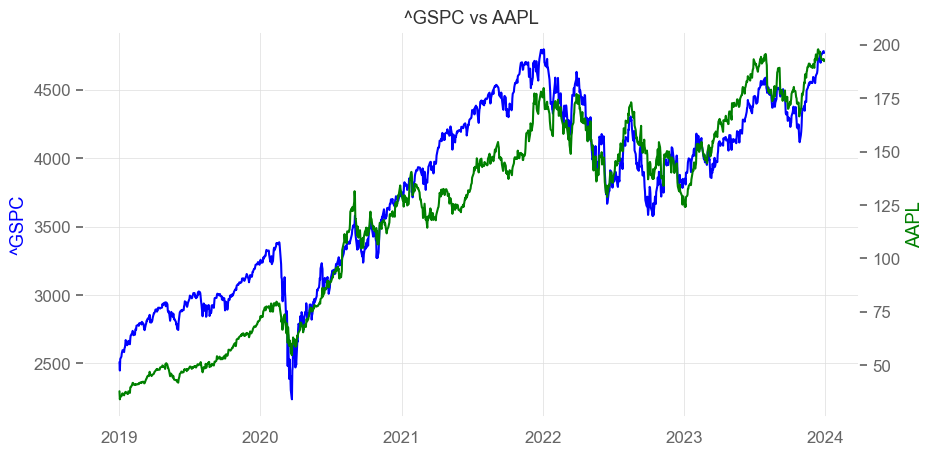

In [25]:
# Plot Market Data
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df[tickers[0]], color='blue') 
plt.ylabel(tickers[0], color='blue')
ax1 = ax.twinx()
ax1.plot(df.index, df[tickers[1]], color='green')
plt.ylabel(tickers[1], color='green')
plt.grid()
plt.title(f'{tickers[0]} vs {tickers[1]}')
plt.show()

Hedge Ratio: 12.7358


/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_15990/1772118179.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = result.params[1]


,^GSPC,AAPL,spread,log_return
Date,,,,
2019-01-02,2510.030029,37.845051,2028.044655,NaN
2019-01-03,2447.889893,34.075401,2013.913858,-0.006992
2019-01-04,2531.939941,35.530045,2079.437924,0.032018
2019-01-07,2549.689941,35.450966,2098.195051,0.008980
2019-01-08,2574.409912,36.126766,2114.308193,0.007650


Text(0.5, 1.0, 'Spread')

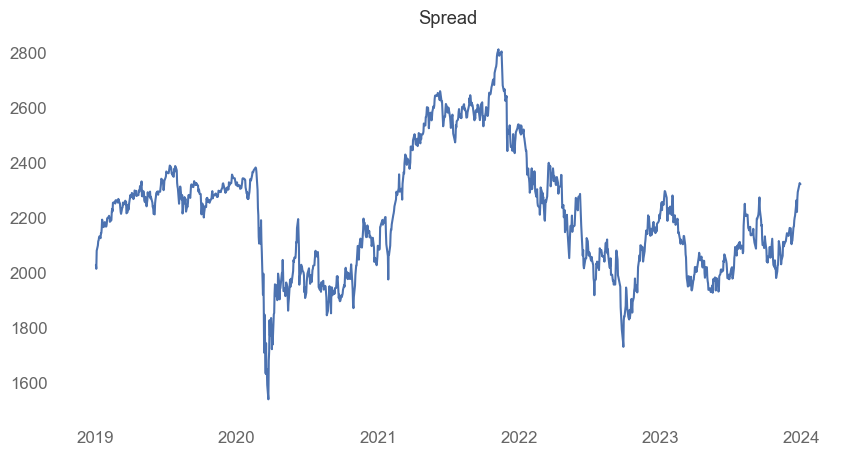

In [26]:
Y = df[tickers[0]]
x = df[tickers[1]]
X = sm.add_constant(x)
result = sm.OLS(Y,X).fit()
hedge_ratio = result.params[1] 
print(f'Hedge Ratio: {hedge_ratio:.4f}')

df['spread'] = Y - hedge_ratio * x
df['log_return'] = np.log(df['spread']/df['spread'].shift(1))
df.head()

fig = plt.figure(figsize=(10,5))
plt.plot(df['spread'])
plt.grid()
plt.title('Spread')
plt.show()

In [27]:
# Test the Spread for Stationarity using ADF

adf = adfuller(df['spread'], maxlag=1)
p_value = adf[1]
print(f'ADF Result Parameters \n{adf}\n') 
print(f'Test Statistic: {adf[0]:.4f}') 
print(f'Critical Value: {adf[4]["5%"]:.4f}')
print(f'P-Value: {adf[1]*100:.4f}%')

ADF Result Parameters 
(-2.36640572388014, 0.15144345209095977, 1, 1256, {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}, 12069.443414772937)

Test Statistic: -2.3664
Critical Value: -2.8638
P-Value: 15.1443%


In [28]:
# Method to Print Stationarity Result

def is_stationary(p_value): 
    if (p_value<0.05):
        print(f'Series is Stationary (p-value {p_value*100:.4f}%)') 
    else:
        print(f'Series NOT Stationary (p-value {p_value*100:.4f}%)') 
    return

is_stationary(p_value)

Series NOT Stationary (p-value 15.1443%)


In [29]:
window = 30
df['mean'] = df['spread'].ewm(span=window).mean() 
df['std'] = df['spread'].ewm(span=window).std()
df.dropna(inplace=True)

df['z_score'] = ( df['spread'] - df['mean'] ) / df['std']
df['z_up'] = 2.0
df['z_down'] = -2.0

In [30]:
# Long Trading Signals
long_entry = (df['z_score'] <= df['z_down'])
long_exit = (df['z_score'] >= 0)
df['long_pos'] = np.nan
df.loc[long_entry, 'long_pos'] = 1
df.loc[long_exit, 'long_pos'] = 0
df['long_pos'].fillna(method='ffill', inplace=True)
df['long_pos'].fillna(0, inplace=True)

# Short Trading Signals
short_entry = (df['z_score'] >= df['z_up'])
short_exit = (df['z_score'] <= 0)
df['short_pos'] = np.nan
df.loc[short_entry, 'short_pos'] = -1 
df.loc[short_exit, 'short_pos'] = 0
df['short_pos'].fillna(method='ffill', inplace=True)
df['short_pos'].fillna(0, inplace=True)

# Total Trading Position
df['total_pos'] = df['long_pos'] + df['short_pos']

/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_15990/109836018.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['long_pos'].fillna(method='ffill', inplace=True)
/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_15990/109836018.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['long_pos'].fillna(method='ffill', inplace=True)
/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_15990/109836018.py:8: Futu

Text(0, 0.5, 'Z-score')

Text(0, 0.5, 'Spread')

Text(0.5, 1.0, 'Z-Scores')

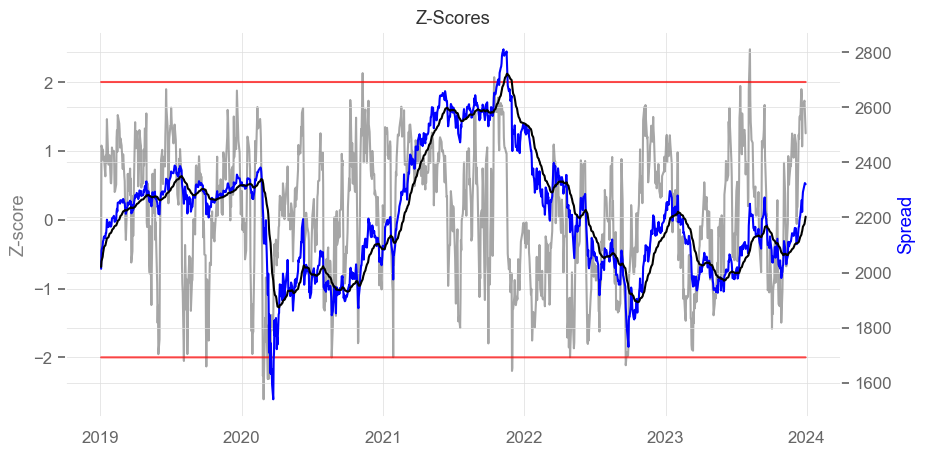

In [31]:
# Plot the Z-Scores
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index, df['z_score'], color='grey', alpha=0.7)
ax.plot(df.index, df['z_up'], color='red', alpha=0.7)
ax.plot(df.index, df['z_down'], color='red', alpha=0.7)
ax.set_ylabel('Z-score', color='grey')
ax1 = ax.twinx()
ax1.plot(df.index, df['spread'], color='blue')
ax1.plot(df.index, df['mean'], color='black')
ax1.set_ylabel('Spread', color='blue')
plt.title('Z-Scores')
plt.show()

Text(0, 0.5, 'Spread')

Text(0, 0.5, 'Trading Position')

Text(0.5, 1.0, 'Trading Positions')

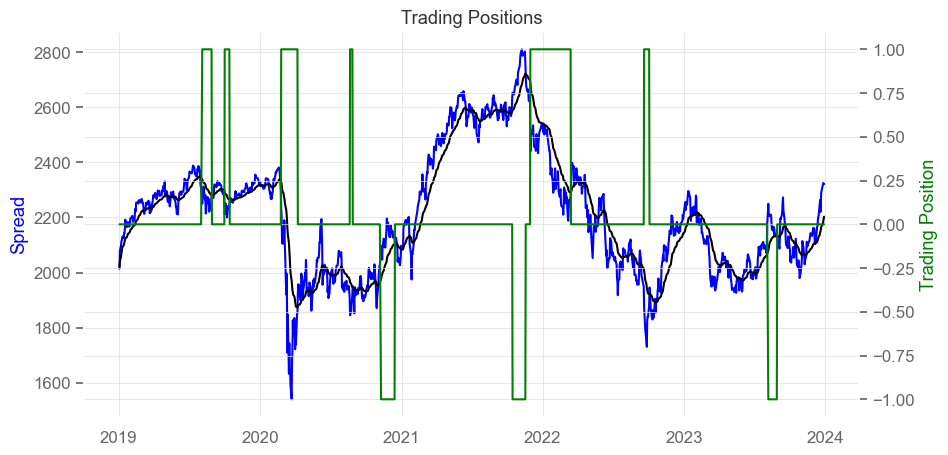

In [32]:
# Plot Trading Positions
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df.index, df['spread'], color='blue')
plt.plot(df.index, df['mean'], color='black')
plt.ylabel('Spread', color='blue')
ax1 = ax.twinx()
ax1.plot(df.index, df['total_pos'], color='green')
ax1.set_ylabel('Trading Position', color='green')
plt.title('Trading Positions')
plt.show()

Daily Sharpe Ratio: -0.0264
Annual Sharpe Ratio: -0.4196


/Users/edo/opt/anaconda3/lib/python3.9/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Strategy
------------------  ----------
Start Period        2019-01-04
End Period          2023-12-29
Risk-Free Rate      5.0%
Time in Market      17.0%

Cumulative Return   -11.09%
CAGR﹪              -1.61%

Sharpe              -0.41
Prob. Sharpe Ratio  2.47%
Sortino             -0.55
Sortino/√2          -0.39
Omega               0.83

Max Drawdown        -33.1%
Longest DD Days     1403

Gain/Pain Ratio     -0.04
Gain/Pain (1M)      -0.16

Payoff Ratio        0.94
Profit Factor       0.96
Common Sense Ratio  1.23
CPC Index           0.46
Tail Ratio          1.28
Outlier Win Ratio   21.8
Outlier Loss Ratio  2.04

MTD                 0.0%
3M                  0.0%
6M                  5.51%
YTD                 5.51%
1Y                  5.51%
3Y (ann.)           -0.43%
5Y (ann.)           -1.64%
10Y (ann.)          -1.61%
All-time (ann.)     -1.61%

Avg. Drawdown       -9.96%
Avg. Drawdown Days  367
Recovery Factor     0.19
Ulcer Index         0.15
Serenity Index      -

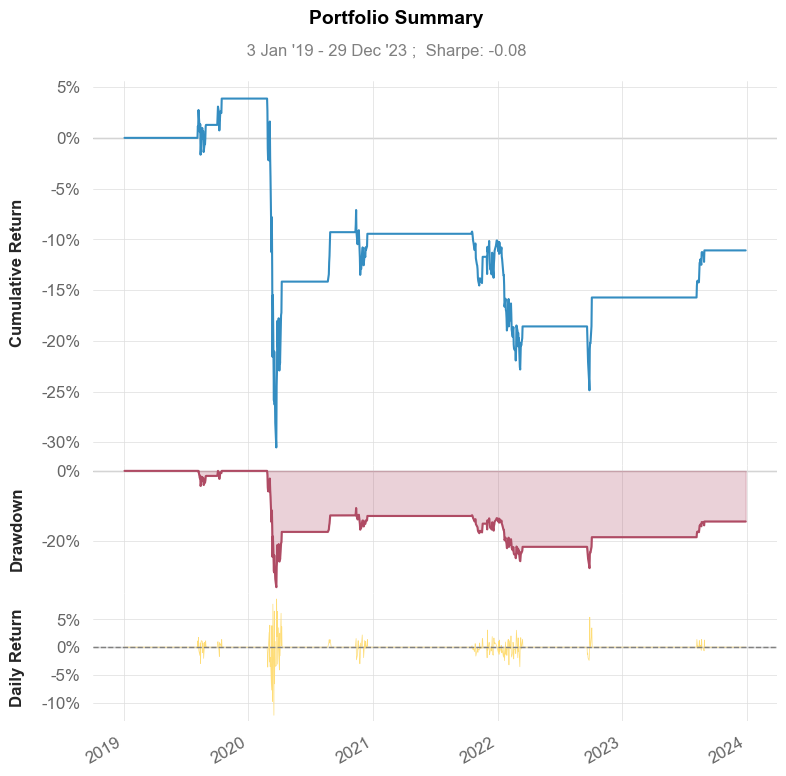

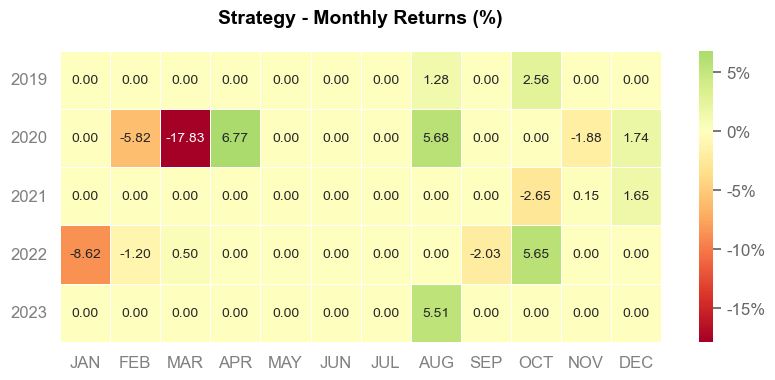

In [33]:
df['strategy_returns'] = df['total_pos'].shift(1) * df['log_return']
strategy_mean = df['strategy_returns'].mean()
strategy_std = df['strategy_returns'].std()

risk_free_rate = 0.05
sharpe_daily = (strategy_mean - (risk_free_rate/252) ) / strategy_std
print(f'Daily Sharpe Ratio: {sharpe_daily:.4f}')
sharpe_annual = sharpe_daily * np.sqrt(252)
print(f'Annual Sharpe Ratio: {sharpe_annual:.4f}')

qs.reports.basic(df['strategy_returns'], rf = risk_free_rate)

In [ ]:
# Credit by Edoardo Alberto Donolato